# Seminar Project: Distance Mapping Using Doc2Vec Embedding and PCA
---------------
``` 

Jakob Amann
Elias Gabriel Heppner, 1244414
Andri Rutschmann

### Loading Packages


In [1]:
import numpy as np 
import pandas as pd 
import time
import pickle
import time
import os
import csv
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Speeches Data


In [2]:
#Define 
os.chdir("../data/kaggle_outputs")
os.getcwd()



'c:\\Users\\elias\\Documents\\Master\\3. Semester\\LLM\\final_project\\Politricks\\data\\kaggle_outputs'

In [3]:
ukraine_speeches = pd.read_pickle('ukraine_war_speeches_manifestoberta.pkl')
migration_speeches = pd.read_pickle('migration_speeches_manifestoberta.pkl')
covid_speeches = pd.read_pickle('covid_speeches_manifestoberta.pkl')
all_speeches = pd.read_pickle('parliament_speeches_with_topics.pkl')

# Now you can work with your loaded DataFrame
all_speeches


,id_x,session,electoral_term,date,document_url,speech_content,politician_id,first_name,last_name,faction_id,abbreviation,full_name,position_short,position_long,speech_tokenized,tokenized_length,topic_label
0,794164,3,18,2013-11-28,https://dip21.bundestag.de/dip21/btp/18/18003.pdf,\nHerr Präsident! Meine Damen und Herren! Lieb...,-1,Not found,,-1,not found,not found,Minister,bundesminister der verteidigung,"[Herr, Präsident, !, Meine, Damen, und, Herren...",764,International
1,794463,3,18,2013-11-28,https://dip21.bundestag.de/dip21/btp/18/18003.pdf,\nHerr Präsident! Meine sehr geehrten Damen un...,-1,Not found,,-1,not found,not found,Minister,bundesminister des auswärtigen,"[Herr, Präsident, !, Meine, sehr, geehrten, Da...",1341,International
2,794871,7,18,2014-01-15,https://dip21.bundestag.de/dip21/btp/18/18007.pdf,\nHerr Präsident! Liebe Kolleginnen und Kolleg...,-1,Not found,,-1,not found,not found,Minister,bundesminister des innern,"[Herr, Präsident, !, Liebe, Kolleginnen, und, ...",1013,Immigration
3,794887,7,18,2014-01-15,https://dip21.bundestag.de/dip21/btp/18/18007.pdf,"\nHerr Abgeordneter, Sie haben drei Sachverhal...",-1,Not found,,-1,not found,not found,Minister,bundesminister des innern,"[Herr, Abgeordneter, ,, Sie, haben, drei, Sach...",301,Immigration
4,794923,7,18,2014-01-15,https://dip21.bundestag.de/dip21/btp/18/18007.pdf,"\nHerr Abgeordneter, das ist ein Aufgabenpaket...",-1,Not found,,-1,not found,not found,Minister,bundesminister des innern,"[Herr, Abgeordneter, ,, das, ist, ein, Aufgabe...",363,Immigration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36048,1068690,23,20,2022-03-22,https://dip21.bundestag.de/dip21/btp/20/20023.pdf,\n\nSehr geehrte Frau Präsidentin! Werte Kolle...,11005031,Dirk,Brandes,0,AfD,Alternative für Deutschland,Member of Parliament,NA,"[Sehr, geehrte, Frau, Präsidentin, !, Werte, K...",583,Transportation
36049,1072715,37,20,2022-05-19,https://dip21.bundestag.de/dip21/btp/20/20037.pdf,\n\nSehr geehrte Frau Präsidentin! Meine vereh...,11005031,Dirk,Brandes,0,AfD,Alternative für Deutschland,Member of Parliament,NA,"[Sehr, geehrte, Frau, Präsidentin, !, Meine, v...",415,Transportation
36050,1069211,25,20,2022-03-24,https://dip21.bundestag.de/dip21/btp/20/20025.pdf,\n\nSehr geehrter Herr Präsident! Sehr geehrte...,11005100,Michael,Kaufmann,0,AfD,Alternative für Deutschland,Member of Parliament,NA,"[Sehr, geehrter, Herr, Präsident, !, Sehr, gee...",468,Government
36051,1071552,34,20,2022-05-12,https://dip21.bundestag.de/dip21/btp/20/20034.pdf,\n\nSehr geehrter Herr Präsident! Werte Kolleg...,11005156,Mike,Moncsek,0,AfD,Alternative für Deutschland,Member of Parliament,NA,"[Sehr, geehrter, Herr, Präsident, !, Werte, Ko...",480,Transportation


In [4]:
# #Remove rows without politician name
# def remove_nonames(df):
#     df.drop(df.loc[df['last_name'] == ''].index, inplace=True)
#     df.reset_index(drop=True, inplace=True)

# for i in [ukraine_speeches, migration_speeches, covid_speeches]:
#     remove_nonames(i)

In [5]:
#find party where missing, if possible
def replace_abbreviations(df):
    for i in range(len(df)):        
        if df.loc[i, 'abbreviation'] == 'not found':
            last_name = df.loc[i, 'last_name']
            first_name = df.loc[i, 'first_name']
    
            correct_abbreviations_df = df[(df['abbreviation'] != 'not found') & (df['last_name'] == last_name) & (df['first_name'] == first_name)]

            try:
                correct_abbreviation = correct_abbreviations_df['abbreviation'].mode()[0] # uses the mode (if someone has two 'parties' (eg. fraktionslos & AfD))
                correct_id = correct_abbreviations_df['faction_id'].mode()[0]
            except:
                correct_abbreviation = None
                correct_id = -1            
    
            df.loc[i, 'abbreviation'] = correct_abbreviation
            df.loc[i, 'faction_id'] = correct_id
            
    print('Unfound abbreviations:', len(df[df['abbreviation'] == None]))
        
        #If still not found, drop
    df.drop(df[df['abbreviation'].isna()].index, inplace=True)
    #df.reset_index(drop=True, inplace=True)

In [6]:
#get whether person was in government or not
def get_govop(df):
    df["gov_op"] = None
    check_groko = (df['electoral_term'] == 18) | (df['electoral_term'] == 19)

    # Assign 1 to 'gov_op' where the electoral term is 18 or 19 and the party is CDU/CSU or SPD
    df.loc[check_groko & (df['abbreviation'].isin(['CDU/CSU', 'SPD'])), 'gov_op'] = 1
    # Assign 0 to 'gov_op' where the electoral term is 18 or 19 and the party is not CDU/CSU or SPD
    df.loc[check_groko & ~(df['abbreviation'].isin(['CDU/CSU', 'SPD'])), 'gov_op'] = 0
    
    check_ampel = df['electoral_term'] == 20
    
    df.loc[check_ampel & df['abbreviation'].isin(['FDP', 'Grüne', 'SPD']), 'gov_op'] = 1
     # Assign 0 to 'gov_op' where the electoral term is 18 or 19 and the party is not CDU/CSU or SPD
    df.loc[check_ampel & ~(df['abbreviation'].isin(['FDP', 'Grüne', 'SPD'])), 'gov_op'] = 0
                
    return df


In [7]:
def get_fullname(df):
    df["full_name"] = df.apply(lambda row: row["first_name"] + ' ' + row["last_name"], axis=1)
    return df

In [8]:
##Apply
for i,j in zip([ukraine_speeches, migration_speeches, covid_speeches], ['n_ukraine_speeches', 'n_migration_speeches', 'n_covid_speeches']):
    replace_abbreviations(i)
    
ukraine_speeches = get_fullname(ukraine_speeches)
covid_speeches = get_fullname(covid_speeches)
migration_speeches = get_fullname(migration_speeches)

ukraine_speeches["abbreviation"] = ukraine_speeches["abbreviation"].replace("DIE LINKE.", "DIE LINKE")
migration_speeches["abbreviation"] = migration_speeches["abbreviation"].replace("DIE LINKE.", "DIE LINKE")
covid_speeches["abbreviation"] = covid_speeches["abbreviation"].replace("DIE LINKE.", "DIE LINKE")

ukraine_speeches = get_govop(ukraine_speeches)
covid_speeches = get_govop(covid_speeches)
migration_speeches = get_govop(migration_speeches)

Unfound abbreviations: 0
Unfound abbreviations: 0
Unfound abbreviations: 0


In [9]:
print(len(ukraine_speeches))
print(len(migration_speeches))
print(len(covid_speeches))

2863
3945
2743


In [10]:
politicians = [{'name' : 'Alexander Gauland', 'party' : 'AfD'},
               {'name' : 'Peter Boehringer', 'party' : 'AfD'},
               {'name' : 'Norbert Kleinwächter', 'party' : 'AfD'},
               {'name' : 'Götz Frömming', 'party' : 'AfD'},
               {'name' : 'Rolf Mützenich', 'party' : 'SPD'},
               {'name' : 'Helge Lindh', 'party' : 'SPD'},
               {'name' : 'Karl Heinz Brunner', 'party' : 'SPD'},
               {'name' : 'Daniela De Ridder', 'party' : 'SPD'},
               {'name' : 'Thorsten Frei', 'party' : 'CDU/CSU'},
               {'name' : 'Alexander Dobrindt', 'party' : 'CDU/CSU'},
               {'name' : 'Philipp Amthor', 'party' : 'CDU/CSU'},
               {'name' : 'Andrea Lindholz', 'party' : 'CDU/CSU'},
               {'name' : 'Thomas Hacker', 'party' : 'FDP'},
               {'name' : 'Christian Lindner', 'party' : 'FDP'},
               {'name' : 'Konstantin Kuhle', 'party' : 'FDP'},
               {'name' : 'Stephan Thomae', 'party' : 'FDP'},
               {'name' : 'Dietmar Bartsch', 'party' : 'DIE LINKE'},
               {'name' : 'Gesine Lötzsch', 'party' : 'DIE LINKE'},
               {'name' : 'Kathrin Vogler', 'party' : 'DIE LINKE'},
               {'name' : 'Heike Hänsel', 'party' : 'DIE LINKE'},
               {'name' : 'Katrin Dagmar Göring-Eckardt', 'party' : 'Grüne'},
               {'name' : 'Annalena Baerbock', 'party' : 'Grüne'},
               {'name' : 'Anton Hofreiter', 'party' : 'Grüne'},
               {'name' : 'Omid Nouripour', 'party' : 'Grüne'}]

politician_df = pd.DataFrame(politicians)
pol_names = politician_df['name'].tolist()


## Load LLM Generated Speeches

In [11]:
os.chdir("../gpt_output")
import json

# Assuming your JSON data is stored in a file named "data.json"
with open("llm_speeches_party.json", "r") as file:
    sp_party = json.load(file)

with open("llm_speeches_pol.json", "r") as file:
    sp_pol = json.load(file)
    
with open("llm_speeches_pol_party.json", "r") as file:
    sp_pol_party = json.load(file)

In [12]:
#turn to df


# Extract data for each row
def conv_dict(llm_dict, doc_type, pol = None):
    
    party_list = []
    name_list = []
    topic_list = []
    content_list = []
    for entry in llm_dict:
        party = entry['party']
        if pol == "pol":
            name = entry['name']
        llm_output = entry['llm_output']
        for topic, content in llm_output.items():
            for item in content:
                party_list.append(party)
                topic_list.append(topic)
                content_list.append(item)
                if pol == "pol":
                    name_list.append(name)

    # Create DataFrame
    dict_df = pd.DataFrame({
        'speech_content': content_list,
        'abbreviation': party_list,
        "full_name": None,
        'topic': topic_list
    })
            
    if pol == "pol":
        dict_df = pd.DataFrame({
        'speech_content': content_list,
        'abbreviation': party_list,
        "full_name": name_list,
        'topic': topic_list
        })
               
    #assume current government as this is waht LLM will do
    dict_df["gov_op"] = None
    dict_df.loc[dict_df['abbreviation'].isin(['FDP', 'Grüne', 'SPD']), 'gov_op'] = 1
    dict_df.loc[~(dict_df['abbreviation'].isin(['FDP', 'Grüne', 'SPD'])), 'gov_op'] = 0
        
    dict_df["doc_type"] = doc_type
    
    return dict_df



In [13]:
llm_part_df = conv_dict(sp_party, "llm_party")# covid_speeches_pols
llm_part_df

,speech_content,abbreviation,full_name,topic,gov_op,doc_type
0,"Sehr geehrte Frau Präsidentin, verehrte Kolleg...",AfD,None,Ukraine-Krieg,0,llm_party
1,"Sehr geehrte Frau Präsidentin, verehrte Kolleg...",AfD,None,Ukraine-Krieg,0,llm_party
2,"Sehr geehrter Herr Präsident, verehrte Kollege...",AfD,None,Ukraine-Krieg,0,llm_party
3,"Sehr geehrte Damen und Herren, verehrte Kolleg...",AfD,None,Ukraine-Krieg,0,llm_party
4,"Meine sehr geehrten Damen und Herren,wir stehe...",AfD,None,Covid-19,0,llm_party
...,...,...,...,...,...,...
67,"Sehr geehrter Herr Bundestagspräsident, sehr g...",Grüne,None,Covid-19,1,llm_party
68,"Sehr geehrte Damen und Herren, verehrte Kolleg...",Grüne,None,Migration,1,llm_party
69,"Sehr geehrte Damen und Herren, sehr geehrter H...",Grüne,None,Migration,1,llm_party
70,"Sehr geehrte Frau Präsidentin, sehr geehrte Mi...",Grüne,None,Migration,1,llm_party


In [14]:
llm_pol_df = conv_dict(sp_pol, "llm_pol", "pol")
llm_pol_df

,speech_content,abbreviation,full_name,topic,gov_op,doc_type
0,"Sehr geehrter Herr Präsident, verehrte Kollegi...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol
1,"Sehr geehrte Frau Präsidentin, verehrte Kolleg...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol
2,"Sehr geehrte Damen und Herren,wir stehen heute...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol
3,"Meine sehr geehrten Damen und Herren,wir stehe...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol
4,"Sehr geehrte Frau Präsidentin, sehr geehrte Da...",AfD,Alexander Gauland,Covid-19,0,llm_pol
...,...,...,...,...,...,...
283,"Sehr geehrte Damen und Herren,verehrte Mitglie...",Grüne,Omid Nouripour,Covid-19,1,llm_pol
284,"Sehr geehrte Frau Präsidentin,sehr geehrter He...",Grüne,Omid Nouripour,Migration,1,llm_pol
285,"Sehr geehrter Herr Bundestagspräsident,sehr ge...",Grüne,Omid Nouripour,Migration,1,llm_pol
286,Sehr geehrter Herr Präsident! Verehrte Abgeord...,Grüne,Omid Nouripour,Migration,1,llm_pol


In [15]:
llm_pol_part_df = conv_dict(sp_pol_party, "llm_pol_party", "pol")# covid_speeches_pols
llm_pol_part_df

,speech_content,abbreviation,full_name,topic,gov_op,doc_type
0,"Sehr geehrte Damen und Herren, liebe Kolleginn...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol_party
1,"Sehr geehrter Herr Präsident, werte Kollegen u...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol_party
2,"Sehr geehrter Herr Präsident, sehr verehrte Da...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol_party
3,"Sehr geehrte Damen und Herren, sehr geehrter H...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol_party
4,"Verehrte Kolleginnen und Kollegen, meine Damen...",AfD,Alexander Gauland,Covid-19,0,llm_pol_party
...,...,...,...,...,...,...
283,"Sehr geehrte Damen und Herren, liebe Kolleginn...",Grüne,Omid Nouripour,Covid-19,1,llm_pol_party
284,"Sehr geehrte Damen und Herren, verehrte Kolleg...",Grüne,Omid Nouripour,Migration,1,llm_pol_party
285,"Sehr geehrte Frau Präsidentin, sehr geehrte Da...",Grüne,Omid Nouripour,Migration,1,llm_pol_party
286,"Sehr geehrte Damen und Herren,ich stehe heute ...",Grüne,Omid Nouripour,Migration,1,llm_pol_party


In [16]:
#Get everything together
def bind_speeches(original_df, topic):
    fin_df = original_df[["speech_content", "abbreviation", "full_name", "gov_op"]]
    fin_df["doc_type"] = "org_speech"
    
    llm_part_top = llm_part_df[llm_part_df["topic"] == topic]
    llm_part_top = llm_part_top.drop(columns=['topic'])
    
    llm_pol_top = llm_pol_df[llm_pol_df["topic"] == topic]
    llm_pol_top = llm_pol_top.drop(columns=['topic'])
    
    llm_pol_part_top = llm_pol_part_df[llm_pol_part_df["topic"] == topic]
    llm_pol_part_top = llm_pol_part_top.drop(columns=['topic'])

    fin_df = pd.concat([fin_df, llm_part_top, llm_pol_top, llm_pol_part_top], ignore_index=True)
    return fin_df

In [17]:
#Apply
covid_speeches_all = bind_speeches(covid_speeches, "Covid-19")
migration_speeches_all = bind_speeches(migration_speeches, "Migration")
ukraine_speeches_all = bind_speeches(ukraine_speeches, "Ukraine-Krieg")


C:\Users\elias\AppData\Local\Temp\ipykernel_880\2748407160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_df["doc_type"] = "org_speech"
C:\Users\elias\AppData\Local\Temp\ipykernel_880\2748407160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_df["doc_type"] = "org_speech"
C:\Users\elias\AppData\Local\Temp\ipykernel_880\2748407160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

## Processing Functions

### Doc2Vec Encoding

In [18]:

import gensim
import nltk
nltk.download('punkt')  # Nur notwendig beim ersten Mal
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
import string
import nltk

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define preprocessing function

def prep_doc2vec(speech_col, df):
    
    def rem_intercept(input_string):
    
        #remove interceptions to speech marked by {0}
        pattern = r'\{\d+\}'
        result_string = re.sub(pattern, '', input_string)
        
        return result_string
    df[speech_col] = df[speech_col].apply(rem_intercept)
    speech_txts = df[speech_col].tolist()
    
    def preprocess_speech(speech_txts, bigram=None, trigram=None):
        # Tokenization
        tokens = word_tokenize(speech_txts, language="german")
        
        # Lowercasing
        tokens = [token.lower() for token in tokens]
        
        # Removing punctuation
        tokens = [token for token in tokens if token not in string.punctuation]
        # Define parliamentary words
        #parl_words = ["kolleginnen", "kollegen", "damen", "herren", "kollege", "kollegin", "präsident", "präsidentin"]
        
        # Removing stopwords 
        #german stopwords
        stop_words = set(stopwords.words('german'))
        tokens = [token for token in tokens if token not in stop_words]
        # #domain stopwords
        # parl_words = ["herr", "frau", "kollegen", "kolleginnen", "liebe", "damen", "präsident", "präsidentin"]
        # token_cop = tokens
        # tokens = []
        # # Apply the filter only to the first 20 tokens, then add the rest unchanged
        # for i, token in enumerate(token_cop):
        #     if i < 30:
        #         if token not in parl_words:
        #             tokens.append(token)
        #     else:
        #         tokens.append(token)
                
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        # Apply bigram phrase model if available
        if bigram:
            tokens = bigram[tokens]
        
        # Apply trigram phrase model if available
        if trigram:
            tokens = trigram[tokens]

        return tokens

    bigram_phrases = Phrases(speech_txts, min_count=1)
    bigram = Phraser(bigram_phrases)
    trigram_phrases = Phrases(bigram[speech_txts], min_count=1)
    trigram = Phraser(trigram_phrases)

    df["tokenized"] = [preprocess_speech(doc, bigram=bigram, trigram=trigram) for doc in speech_txts]
    
    return df


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:

class DataFrameIterator(object):
    def __init__(self, dataframe, party_col=None, name_col=None, pos_col=None, gov_col=None):
        self.dataframe = dataframe
        self.party_col = party_col
        self.name_col = name_col
        self.pos_col = pos_col
        self.gov_col = gov_col

    def __iter__(self):
        for index, row in self.dataframe.iterrows():
            tags = []
            if self.party_col is not None:
                tags.append(str(row[self.party_col]))
            if self.name_col is not None:
                tags.append(str(row[self.name_col]))
            if self.pos_col is not None:
                tags.append(str(row[self.pos_col]))
            if self.gov_col is not None:
                tags.append(str(row[self.gov_col]))
            words = row['tokenized']
            yield TaggedDocument(words=words, tags=tags)


# Tag documents using party and/or name as metadata
# If you only want to use polname, set party_column=None
# If you only want to use abbreviation, set name_column=None
# ...and so on

### PCA

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def run_pca(df, title, file_name):
    
    # Infer vectors for each document in your corpus
    document_vectors = [model.infer_vector(doc) for doc in df["tokenized"]]

    # Convert the list of document vectors into a numpy array
    document_vectors_np = np.array(document_vectors)

    # Apply PCA
    pca = PCA(n_components=2)  # You can change the number of components as needed
    document_embeddings = pca.fit_transform(document_vectors_np)

    ############################################################################
    # Get loadings

    feature_names = model.wv.index_to_key    
    def get_loadings(component, pc):
            
        # Get the top 10 words with highest loadings
        num_top_words = 10
        
        pc_loads = pd.DataFrame(columns=['high', 'low'])
        # Create a dictionary to store word loadings
        word_loadings = dict(zip(feature_names, component))

        # Sort the words based on their loadings
        sorted_words = sorted(word_loadings.items(), key=lambda x: abs(x[1]), reverse=True)

        top_words_highest_loadings = [word for word, _ in sorted_words[:num_top_words]]
        top_words_lowest_loadings = [word for word, _ in sorted_words[-num_top_words:]]

        # Add the lists of top words to the DataFrame
        pc_loads['high'] = top_words_highest_loadings
        pc_loads['low'] = top_words_lowest_loadings
        pc_loads['pc'] = pc

        return pc_loads
    pc_loads_1 = get_loadings(pca.components_[0], 1)
    pc_loads_2 = get_loadings(pca.components_[1], 2)
    
    ############################################################################
    # Get pca placings summary statistics
    
    def get_pca_stats(doc_type, politician = None):
        pca_stats_list = []
        
        # Compute mean and median values
    
        if politician != "pol":        
            for party in df["abbreviation"].unique():
                party_indices = df[(df["abbreviation"] == party) & (df["doc_type"] == doc_type)].index
                party_component_values = document_embeddings[party_indices]
                # Compute mean and median values
                mean_value = np.mean(party_component_values, axis=0)
                median_value = np.median(party_component_values, axis=0)

                # Append mean and median values to pc_vals_part_list
                pca_stats_list.append({"pc": 1, "party": party, "mean": mean_value[0], "median": median_value[0], "doc_type": doc_type})
                pca_stats_list.append({"pc": 2, "party": party, "mean": mean_value[1], "median": median_value[1], "doc_type": doc_type})
        
        if politician == "pol":
            for index, row in politician_df.iterrows():
                pol_indices = df[(df["full_name"] == row['name']) & (df["doc_type"] == doc_type)].index
                pol_component_values = document_embeddings[pol_indices]

                # Compute mean and median values
                mean_value = np.mean(pol_component_values, axis=0)
                median_value = np.median(pol_component_values, axis=0)

                # Append mean and median values to pc_vals_part_list
                pca_stats_list.append({"pc": 1, "politician": row['name'], "party": row['party'], "mean": mean_value[0], "median": median_value[0], "doc_type": doc_type})
                pca_stats_list.append({"pc": 2, "politician": row['name'], "party": row['party'], "mean": mean_value[1], "median": median_value[1], "doc_type": doc_type})

        pca_stats_df = pd.DataFrame(pca_stats_list)

        return pca_stats_df

    pc_vals_par_org = get_pca_stats("org_speech")
    pc_vals_par_org["doc_type"] = "org_party"
    pc_vals_par_llm = get_pca_stats("llm_party")
    pc_vals_pol_org = get_pca_stats("org_speech", "pol")
    pc_vals_pol_org["doc_type"] = "org_pol"
    pc_vals_pol_llm = get_pca_stats("llm_pol", "pol")
    pc_vals_pol_par_llm = get_pca_stats("llm_pol_party", "pol")

    ############################################################################
    ##Plot

    # Define custom colors for each abbreviation
    abbreviation_colors = {
        'CDU/CSU': 'black',
        'DIE LINKE': 'pink',
        'SPD': 'red',
        'AfD':'blue',
        'FDP': 'yellow',
        'Grüne': 'green',
        'Fraktionslos': 'grey',
        'not found': 'magenta',
    }

    # Plot the embeddings with color coding by string categories and custom colors
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(document_embeddings[:, 0], document_embeddings[:, 1], c=df["abbreviation"].map(abbreviation_colors), alpha=0.4)

    # Create custom legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=abbreviation, linestyle='', alpha=0.5) for abbreviation, color in abbreviation_colors.items()]
    legend1 = plt.legend(handles=legend_elements, title="Party", loc='upper left')

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)

    # Add legend to the plot
    plt.gca().add_artist(legend1)

    x_max = np.max(document_embeddings[:, 0])
    y_max = np.max(document_embeddings[:, 1])
    x_min = np.min(document_embeddings[:, 0])
    y_min = np.min(document_embeddings[:, 1])
    
    plt.xlim(x_min -0.5 , x_max + 0.5)
    plt.ylim(y_min -0.5, y_max + 0.5)


    plt.savefig(file_name)
    plt.show()
     
    return pc_loads_1, pc_loads_2, pc_vals_par_org, pc_vals_par_llm, pc_vals_pol_org, pc_vals_pol_llm, pc_vals_pol_par_llm



## Application and Evaluation

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def apply_pca(input_df):
    input_df = prep_doc2vec("speech_content", input_df)
    input_df.reset_index(drop=True, inplace=True)
    tagged_data = DataFrameIterator(input_df, party_col=None, name_col=None, pos_col=None, gov_col="gov_op")
    

    #The wide window was chosen as it was shown to work best on speech data. See: #### INSERT

    # Build vocabulary
    model.build_vocab(tagged_data)

    # Train the model
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)


### Case 1: All Speeches


Get the PCA for all original and artificial speeches by topic

# ADD EXPLANATIONS

c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


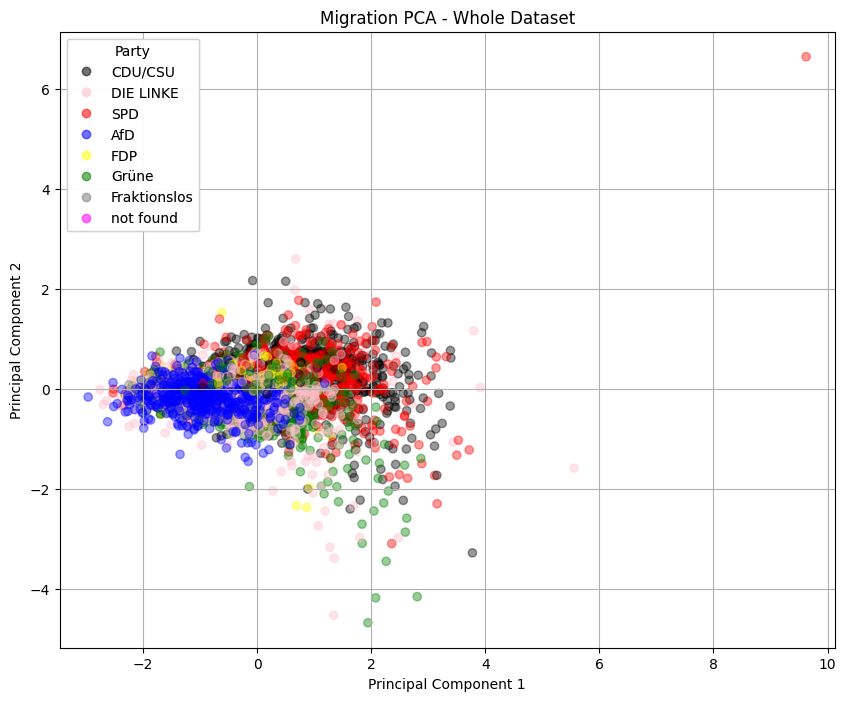

          high           low  pc
0       besser            ja   1
1     bedeutet      deutlich   1
2   allerdings        stellt   1
3  tatsächlich       ländern   1
4        punkt        türkei   1
5  unternehmen   flüchtlinge   1
6       region          gute   1
7  politischen       leisten   1
8     bekommen       handeln   1
9      problem  gesellschaft   1        high            low  pc
0    linken           eben   2
1    region  unterstützung   2
2  minister              “   2
3     schon        politik   2
4    führen         bleibt   2
5    gesetz       sprechen   2
6     blick           sagt   2
7    sicher        richtig   2
8   monaten         sollen   2
9  deutlich          hätte   2


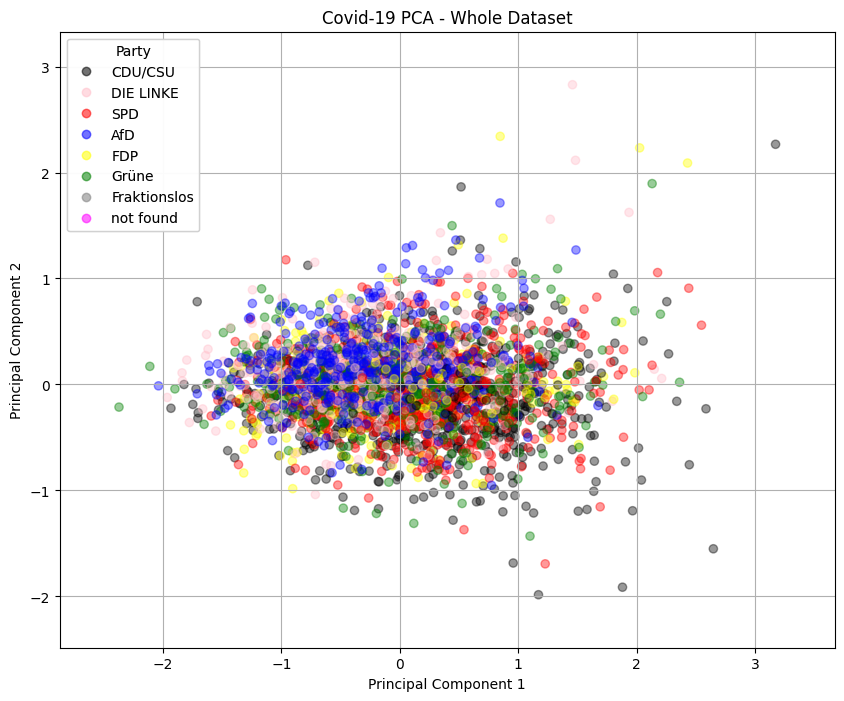

          high            low  pc
0     pandemie       deswegen   1
1           ja      natürlich   1
2        viele           fall   1
3     lockdown        debatte   1
4         ganz         wurden   1
5      bildung        wichtig   1
6       gerade        letzten   1
7        heißt  investitionen   1
8        frage   insbesondere   1
9  bevölkerung          dabei   1          high              low  pc
0     sollten         covid-19   2
1       davon            jahre   2
2   situation            lange   2
3  milliarden              sei   2
4        weit           sollen   2
5    kommunen          schritt   2
6    lockdown            große   2
7     unserer  digitalisierung   2
8       heute          einfach   2
9       woche         menschen   2


c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


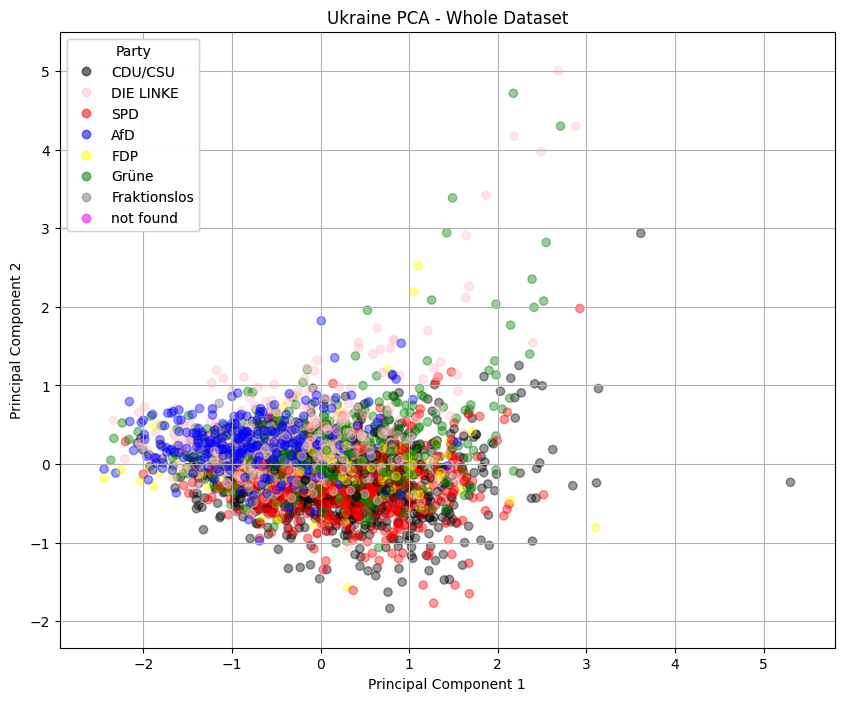

           high        low  pc
0  europäischen     region   1
1        gerade       jahr   1
2    bundeswehr       geld   1
3       endlich       beim   1
4       staaten  interesse   1
5          seit  notwendig   1
6          zwei     landes   1
7        müssen    zukunft   1
8      deswegen      daher   1
9  gesellschaft      krise   1          high           low  pc
0     nämlich          haus   2
1     ukraine  angesprochen   2
2     endlich      schaffen   2
3       reden     weiterhin   2
4        gibt         genau   2
5       wurde       aufgabe   2
6  vielleicht   präsidentin   2
7         afd       zukunft   2
8      müssen      zusammen   2
9      gehört          neue   2


In [22]:
#Migration
model = Doc2Vec(vector_size=300, window=20, min_count=50, workers=8, epochs=8)
appl_df = migration_speeches_all.copy()
apply_pca(appl_df)

mig_loads_1, mig_loads_2, org_part_mig, llm_part_mig, org_pol_mig, llm_pol_mig, llm_polpar_mig = run_pca(appl_df, "Migration PCA - Whole Dataset", "../pca_output/migration_all.png")
print(mig_loads_1, mig_loads_2)
#Covid
model = Doc2Vec(vector_size=300, window=20, min_count=50, workers=8, epochs=8)
appl_df = covid_speeches_all.copy()
apply_pca(appl_df)
cov_loads_1, cov_loads_2, org_part_cov, llm_part_cov, org_pol_cov, llm_pol_cov, llm_polpar_cov = run_pca(appl_df, "Covid-19 PCA - Whole Dataset", "../pca_output/covid_all.png")
print(cov_loads_1, cov_loads_2)

#Ukraine
model = Doc2Vec(vector_size=300, window=20, min_count=50, workers=8, epochs=8)
appl_df = ukraine_speeches_all.copy()
apply_pca(appl_df)
ukr_loads_1, ukr_loads_2, org_part_ukr, llm_part_ukr, org_pol_ukr, llm_pol_ukr, llm_polpar_ukr = run_pca(appl_df, "Ukraine PCA - Whole Dataset", "../pca_output/ukraine_all.png")
print(ukr_loads_1, ukr_loads_2)

In [23]:
def get_sum_vis(input_df, title, file_name, politician = None):

    abbreviation_colors = {
        'CDU/CSU': 'black',
        'DIE LINKE': 'pink',
        'SPD': 'red',
        'AfD': 'blue',
        'FDP': 'yellow',
        'Grüne': 'green',
        }
    
    input_df = input_df[(input_df["party"] != "not found") & (input_df["party"] != "Fraktionslos")]

    #ilter data for PC == 1 and PC == 2
    pc1_mean = input_df['mean'][input_df['pc'] == 1]
    pc2_mean = input_df['mean'][input_df['pc'] == 2]

    pc_party = input_df['party'][input_df['pc'] == 1]
    doc_type = input_df['doc_type'][input_df['pc'] == 1]                

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(pc1_mean, pc2_mean, c=[abbreviation_colors[party] for party in pc_party])
    plt.title(title)
    plt.xlabel('Mean for PC1')
    plt.ylabel('Mean for PC2')

    for i, txt in enumerate(doc_type):
        plt.annotate(txt, (pc1_mean.iloc[i], pc2_mean.iloc[i]), fontsize=8, ha='right', va='bottom')

    legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=party, linestyle='') for party, color in abbreviation_colors.items()]
    legend1 = plt.legend(handles=legend_elements, title="Party", loc='upper left')

    # Add legend to the plot
    plt.gca().add_artist(legend1)
    plt.grid(True)
    plt.savefig(file_name)
    plt.show()


### In-Depth View at Migation

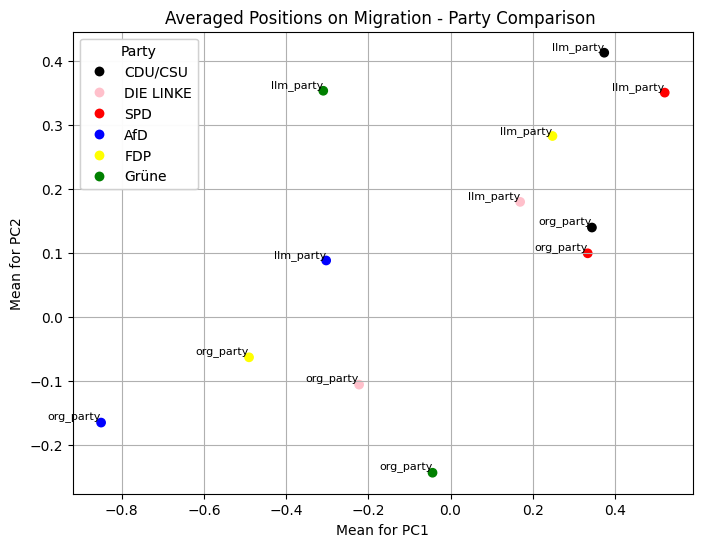

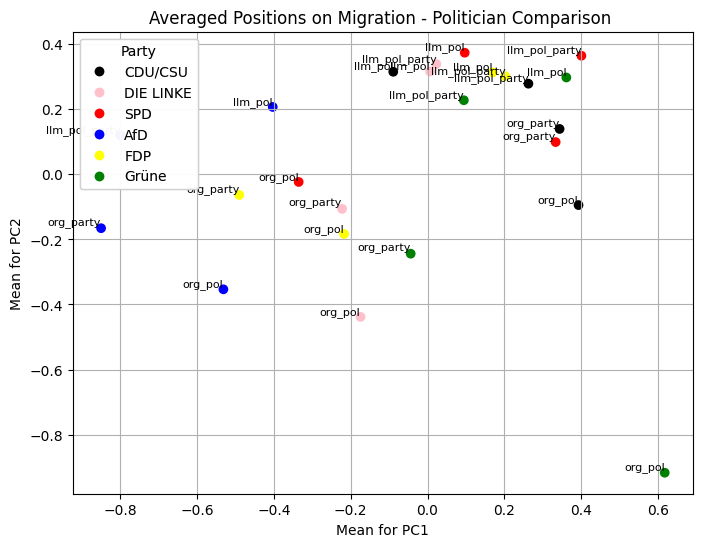

In [24]:
# # Data
# org_part_mig 
# org_part_mig["doc_type"] = "org_party"
# llm_part_mig
# org_pol_mig
# llm_pol_mig
# llm_polpar_mig
appl_df = pd.concat([org_part_mig, llm_part_mig])
get_sum_vis(appl_df, "Averaged Positions on Migration - Party Comparison ", "../pca_output/avg_mig_party.png")

#Compare Politician Aggregations

org_pol_mig_aggr = org_pol_mig.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
org_pol_mig_aggr = org_pol_mig_aggr.reset_index()

llm_pol_mig_aggr = llm_pol_mig.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_pol_mig_aggr = llm_pol_mig_aggr.reset_index()

llm_polpar_mig_aggr = llm_polpar_mig.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_polpar_mig_aggr = llm_polpar_mig_aggr.reset_index()

appl_df = pd.concat([org_part_mig, org_pol_mig_aggr, llm_pol_mig_aggr, llm_polpar_mig_aggr])
get_sum_vis(appl_df, "Averaged Positions on Migration - Politician Comparison ", "../pca_output/avg_mig_pol.png")

### In-Depth Vew at Covid

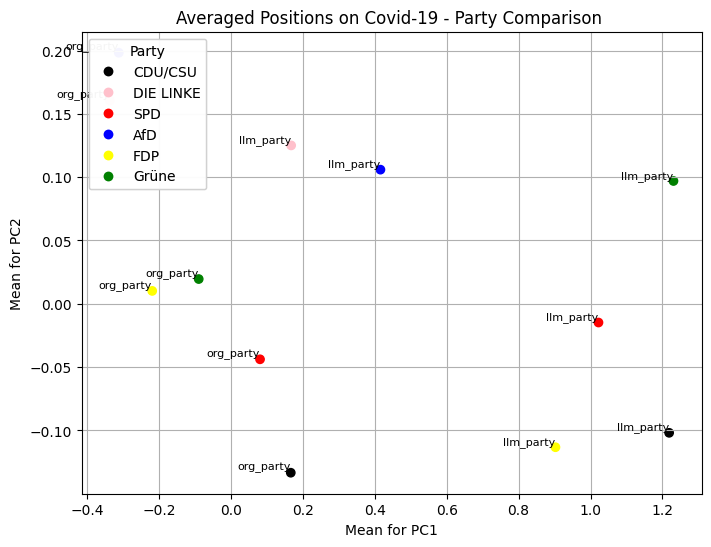

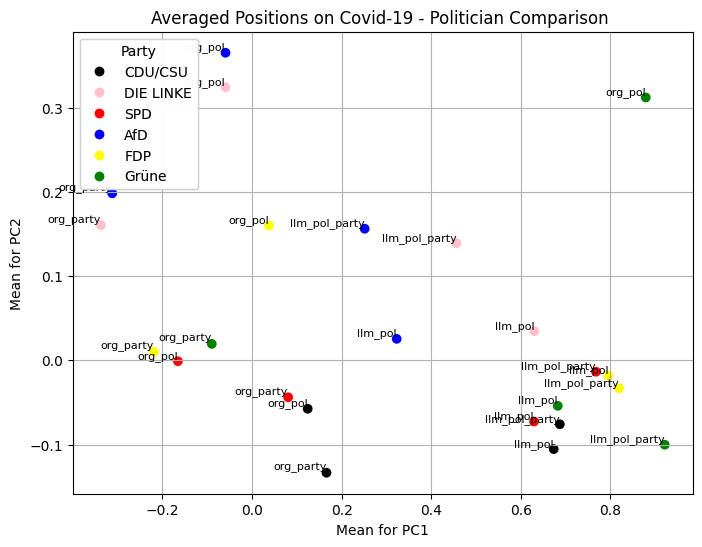

In [25]:
appl_df = pd.concat([org_part_cov, llm_part_cov])
get_sum_vis(appl_df, "Averaged Positions on Covid-19 - Party Comparison ", "../pca_output/avg_cov_party.png")

#Compare Politician Aggregations

org_pol_cov_aggr = org_pol_cov.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
org_pol_cov_aggr = org_pol_cov_aggr.reset_index()

llm_pol_cov_aggr = llm_pol_cov.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_pol_cov_aggr = llm_pol_cov_aggr.reset_index()

llm_polpar_cov_aggr = llm_polpar_cov.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_polpar_cov_aggr = llm_polpar_cov_aggr.reset_index()

appl_df = pd.concat([org_part_cov, org_pol_cov_aggr, llm_pol_cov_aggr, llm_polpar_cov_aggr])
get_sum_vis(appl_df, "Averaged Positions on Covid-19 - Politician Comparison ", "../pca_output/avg_cov_pol.png")

### In-Depth View at the War in Ukraine

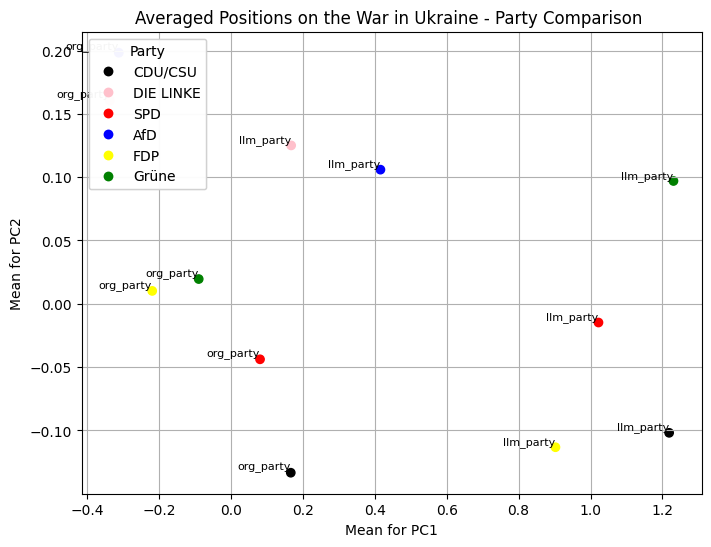

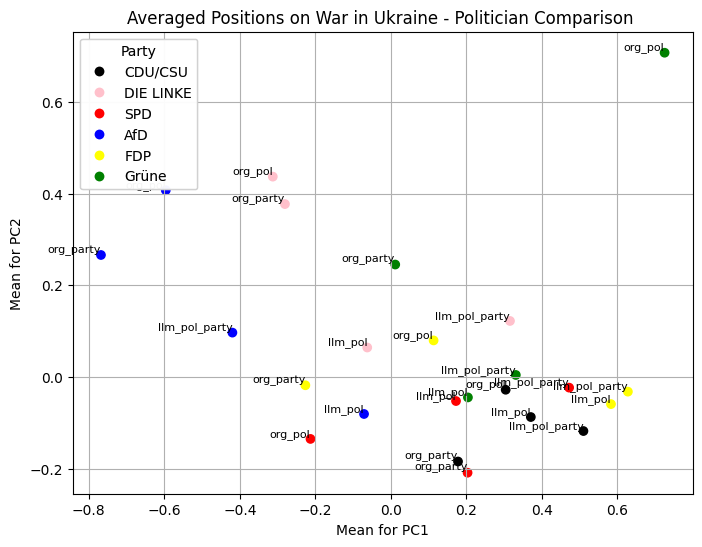

In [26]:
appl_df = pd.concat([org_part_cov, llm_part_cov])
get_sum_vis(appl_df, "Averaged Positions on the War in Ukraine - Party Comparison ", "../pca_output/avg_ukr_party.png")

#Compare Politician Aggregations

org_pol_ukr_aggr = org_pol_ukr.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
org_pol_ukr_aggr = org_pol_ukr_aggr.reset_index()

llm_pol_ukr_aggr = llm_pol_ukr.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_pol_ukr_aggr = llm_pol_ukr_aggr.reset_index()

llm_polpar_ukr_aggr = llm_polpar_ukr.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_polpar_ukr_aggr = llm_polpar_ukr_aggr.reset_index()

appl_df = pd.concat([org_part_ukr, org_pol_ukr_aggr, llm_pol_ukr_aggr, llm_polpar_ukr_aggr])
get_sum_vis(appl_df, "Averaged Positions on War in Ukraine - Politician Comparison ", "../pca_output/avg_ukr_pol.png")

### In-Depth Look at Individual Politicians

Can't look through this much qualitatively, just some for investigation

In [31]:
in_depth_mig = pd.concat([org_pol_mig, llm_polpar_mig, llm_pol_mig])
in_depth_cov = pd.concat([org_pol_cov, llm_polpar_cov, llm_pol_cov])
in_depth_ukr = pd.concat([org_pol_ukr, llm_polpar_ukr, llm_pol_ukr])

abaer =  in_depth_ukr[in_depth_pol["politician"] == "Annalena Baerbock"]
agaul = in_depth_cov[in_depth_pol["politician"] == "Alexander Gauland"]	
pamt = in_depth_mig[in_depth_pol["politician"] == "Philipp Amthor"]	


In [32]:
abaer

# all very far apart

,pc,politician,party,mean,median,doc_type
42,1,Annalena Baerbock,Grüne,0.295114,0.295184,org_pol
43,2,Annalena Baerbock,Grüne,0.232344,0.228879,org_pol
42,1,Annalena Baerbock,Grüne,0.665083,0.764073,llm_pol_party
43,2,Annalena Baerbock,Grüne,-0.062117,-0.116054,llm_pol_party
42,1,Annalena Baerbock,Grüne,0.055225,0.093985,llm_pol
43,2,Annalena Baerbock,Grüne,0.028982,0.013016,llm_pol


In [33]:
agaul

# all very far apart too

,pc,politician,party,mean,median,doc_type
0,1,Alexander Gauland,AfD,-0.435329,-0.508940,org_pol
1,2,Alexander Gauland,AfD,0.323574,0.252781,org_pol
0,1,Alexander Gauland,AfD,0.021784,-0.003986,llm_pol_party
1,2,Alexander Gauland,AfD,0.256499,0.279943,llm_pol_party
0,1,Alexander Gauland,AfD,0.587842,0.510013,llm_pol
1,2,Alexander Gauland,AfD,0.099501,0.077460,llm_pol


In [34]:
pamt

#this is  quite good give the axis dimensions

,pc,politician,party,mean,median,doc_type
20,1,Philipp Amthor,CDU/CSU,-0.079909,-0.265974,org_pol
21,2,Philipp Amthor,CDU/CSU,-0.091544,-0.120025,org_pol
20,1,Philipp Amthor,CDU/CSU,0.102507,0.091903,llm_pol_party
21,2,Philipp Amthor,CDU/CSU,0.253658,0.264315,llm_pol_party
20,1,Philipp Amthor,CDU/CSU,-0.238137,-0.373399,llm_pol
21,2,Philipp Amthor,CDU/CSU,0.213683,0.197090,llm_pol


In [ ]:
# do it quantitatively: average total distance



### Case 2/3: Politician and Politician/Party Positions

Get the PCA for all original speeches and politicians by topic in subset of politicians

In [30]:
pol_names = politician_df['name'].tolist()

covid_speeches_pols = covid_speeches_all[covid_speeches_all['full_name'].isin(pol_names)]
ukraine_speeches_pols = ukraine_speeches_all[ukraine_speeches_all['full_name'].isin(pol_names)]
migration_speeches_pols = migration_speeches_all[migration_speeches_all['full_name'].isin(pol_names)]

#Migration
model = Doc2Vec(vector_size=200, window=30, min_count=40, workers=8, epochs=8)
appl_df = migration_speeches_pols.copy()
apply_pca(appl_df)

mig_loads_1_sub, mig_loads_2_sub, org_part_mig_sub, llm_part_mig_sub, org_pol_mig_sub, llm_pol_mig_sub, llm_polpar_mig_sub = run_pca(appl_df, "Migration PCA - Prompted Politcians Dataset", "../pca_output/migration_pols.png")
print(mig_loads_1_sub, mig_loads_2_sub)

#Covid
model = Doc2Vec(vector_size=200, window=30, min_count=40, workers=8, epochs=8)

appl_df = covid_speeches_pols.copy()
apply_pca(appl_df)
cov_loads_1_sub, cov_loads_2_sub, org_part_cov_sub, llm_part_cov_sub, org_pol_cov_sub, llm_pol_cov_sub, llm_polpar_cov_sub = run_pca(appl_df, "Covid-19 PCA -  Prompted Politcians Dataset", "../pca_output/covid_pols.png")
print(cov_loads_1_sub, cov_loads_2_sub)

# #Ukraine
model = Doc2Vec(vector_size=200, window=30, min_count=40, workers=8, epochs=8)

appl_df = ukraine_speeches_pols.copy()
apply_pca(appl_df)
ukr_loads_1_sub, ukr_loads_2_sub, org_part_ukr_sub, llm_part_ukr_sub, org_pol_ukr_sub, llm_pol_ukr_sub, llm_polpar_ukr_sub = run_pca(appl_df, "Ukraine PCA -  Prompted Politcians Dataset", "../pca_output/ukraine_pols.png")
print(ukr_loads_1_sub, ukr_loads_2_sub)


NameError: name 'mig_loads_1_sub' is not defined